In [11]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [12]:
# ---- step 1 load and convert image ----
image_path = r"C:\Users\EVO\Desktop\DataProjects\Closed_Contour_Detection\bananapic.jpg"
image = Image.open(image_path).convert('L')
image_array = np.array(image)

In [13]:
# --- Step 2: Define the 8 Kirsch kernels ---
KIRSCH_KERNELS = [
    np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),        # Nord
    np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]),       # Nord-Est
    np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]),       # Est
    np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]),       # Sud-Est
    np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]),       # Sud
    np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]),       # Sud-Ouest
    np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]),       # Ouest
    np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]])        # Nord-Ouest
]

In [14]:
# --- Step 3: Apply the Kirsch filter ---
def apply_kirsch_filter(image_data, kernels):
    """Applique les 8 masques de Kirsch et garde le maximum."""
    padded_image = np.pad(image_data, pad_width=1, mode='constant', constant_values=0)
    rows, cols = image_data.shape
    responses = []

    for kernel in kernels:
        response = np.zeros_like(image_data, dtype=np.float32)
        for i in range(1, rows + 1):
            for j in range(1, cols + 1):
                region = padded_image[i - 1:i + 2, j - 1:j + 2]
                value = np.sum(region * kernel)
                response[i - 1, j - 1] = value
        responses.append(response)

    final_response = np.maximum.reduce(responses)
    return np.clip(final_response, 0, 255).astype(np.uint8)

In [15]:
# --- Step 4: Otsu's method for automatic thresholding ---
def otsu_threshold(image_data):
    """Calcule le seuil optimal via la méthode d'Otsu."""
    histogram, _ = np.histogram(image_data, bins=256, range=(0, 256))
    total_pixels = image_data.size

    current_max = 0
    threshold_val = 0
    sum_total = np.dot(np.arange(256), histogram)
    sum_background = 0
    weight_background = 0

    for t in range(256):
        weight_background += histogram[t]
        if weight_background == 0:
            continue

        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break

        sum_background += t * histogram[t]
        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground

        # Formule de la variance inter-classe
        variance = (weight_background * weight_foreground * (mean_background - mean_foreground) ** 2)

        if variance > current_max:
            current_max = variance
            threshold_val = t

    return threshold_val

In [16]:
# --- Step 5 : 
def binarize_image(image_data, threshold_val):
    """Convertit l'image en noir et blanc selon le seuil."""
    return np.where(image_data > threshold_val, 255, 0).astype(np.uint8)


def segment_and_verify_closed_contours(binary_image):
    """Détecte et remplit les contours convexes."""
    contours, _ = cv2.findContours(
        binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    closed_contours = [c for c in contours if cv2.isContourConvex(c)]
   
    segmented_image = np.zeros_like(binary_image)
    cv2.drawContours(segmented_image, closed_contours, -1, 255, thickness=cv2.FILLED)
    
    return segmented_image, closed_contours

In [17]:
# --- Main Execution ---
kirsch_edges = apply_kirsch_filter(image_array, KIRSCH_KERNELS)
auto_threshold = otsu_threshold(kirsch_edges)
print(f"Seuil automatique (Otsu) = {auto_threshold}")

binary_edges = binarize_image(kirsch_edges, auto_threshold)
segmented_img, final_contours = segment_and_verify_closed_contours(binary_edges)

Seuil automatique (Otsu) = 111


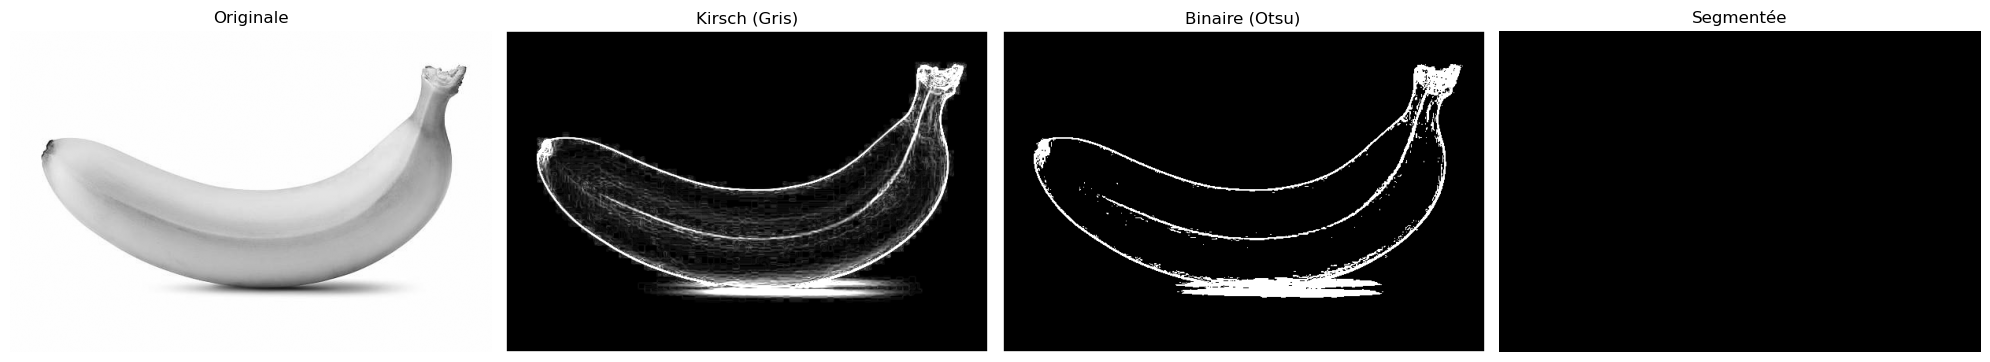

Nombre de contours fermés détectés : 1


In [19]:
# --- Results Visualization ---
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
titles = ["Originale", "Kirsch (Gris)", "Binaire (Otsu)", "Segmentée"]
images = [image_array, kirsch_edges, binary_edges, segmented_img]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Nombre de contours fermés détectés : {len(final_contours)}")